In [1]:
import os
from pathlib import Path
from typing import Callable, Optional, Union
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import arviz as az

import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt
import seaborn as sns

from .src.preprocessing import encode_distance_setting, encode_number_of_objects
from .src.helpers import compute_dprime, compute_criterion

In [2]:
# optionally add graphviz to PATH
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

## Load Data

In [3]:
path_all = Path(os.getcwd()).parent / 'data' / 'processed_data' / 'cleaned_shape_experiment_1.csv'  # all data, cleaned up for SDT
path_sum = Path(os.getcwd()).parent / 'data' / 'processed_data' / 'hit_fa_summary_shape_experiment_1.csv' # summary DataFrame

In [4]:
df = pd.read_csv(path_all)
summary = pd.read_csv(path_sum)

In [5]:
df.shape

(14800, 22)

In [6]:
df.head(2)

,participant,distance_setting,number_of_objects,trial_number,target_present,ran,order,response_yes,yes_no_correct,hit,...,rt_where_sec,response_where_x,response_where_y,target_pos_x,target_pos_y,click_distance_deg,distance_shapecomp,background_shape_idx,proto_object_idx,date_str
0,SR,low,3,1,False,1.0,0.0,0.0,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,-1.0,2023-06-26_15h38.26.579
1,SR,low,3,2,True,1.0,1.0,1.0,1.0,1,...,0.303415,-2.645458,-6.242093,-5.434043,-1.889708,5.169086,0.514986,0.0,39.0,2023-06-26_15h38.26.579


In [7]:
summary.shape

(146, 10)

In [8]:
summary.head(2)

,participant,distance_setting,number_of_objects,n_hit,n_fa,n_signal,n_noise,proportion_correct,hit_rate,false_alarm_rate
0,DB,high,2,46,5,50,50,0.91,0.903846,0.115385
1,DB,high,3,47,2,50,50,0.95,0.923077,0.057692


In [9]:
df['distance_setting_code']  = encode_distance_setting(df['distance_setting'])
df['number_of_objects_code'] = encode_number_of_objects(df['number_of_objects'])

summary['distance_setting_code']  = encode_distance_setting(summary['distance_setting'])
summary['number_of_objects_code'] = encode_number_of_objects(summary['number_of_objects'])

print('distance_setting_code' in df.columns      and 'number_of_objects_code' in df.columns)
print('distance_setting_code' in summary.columns and 'number_of_objects_code' in summary.columns)

True
True


In [10]:
summary['dprime'] = compute_dprime(summary['hit_rate'], summary['false_alarm_rate'])
summary['lambda'] = compute_criterion(summary['false_alarm_rate'])

summary[['dprime', 'lambda']].describe()

,dprime,lambda
count,146.000000,146.000000
mean,1.621773,1.065357
std,0.914764,0.470423
min,-1.018592,-0.344102
25%,0.868500,0.801095
50%,1.572630,1.020076
75%,2.301287,1.426077
max,4.139804,2.069902


## Simple GLM

In [24]:
def glm(
    target_present : jnp.ndarray, 
    response_yes : Optional[jnp.ndarray] = None
) -> None:
    """
    Fits an equal variance gaussian SDT model based on a probit GLM to the data.
    For discussion, see DeCarlo (1998).

    Parameters:
        target_present : jnp.ndarray
            For each trial, whether the trial contained a target.
            Each value can be 0 or 1.
        response_yes   : jnp.ndarray
            For each trial, whether the participant responded yes on the yes-no task.
            Each value can be 0 or 1.
    Returns
        None
    """
    # intercept aka criterion
    beta_0 = numpyro.sample('beta_0', dist.Normal(0, 5))

    # coefficient aka d'
    beta_1 = numpyro.sample('beta_1', dist.Normal(0, 5))
    
    with numpyro.plate(name='data', size=target_present.size):
        # linear predictor
        eta = numpyro.deterministic(name='eta', value=beta_0 + beta_1 * target_present)

        # probit link
        p = dist.Normal().cdf(eta)
        
        numpyro.sample('obs', dist.Bernoulli(probs=p), obs=response_yes)

In [25]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(glm)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(
    rng_key_,
    target_present=jnp.asarray(df['target_present'].values).astype(int),
    response_yes=jnp.asarray(df['response_yes'].values).astype(int)
)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:10<00:00, 278.54it/s, 3 steps of size 6.17e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -1.02      0.02     -1.02     -1.05     -0.99    558.69      1.00
    beta_1      1.50      0.02      1.50      1.46      1.53    600.39      1.00

Number of divergences: 0


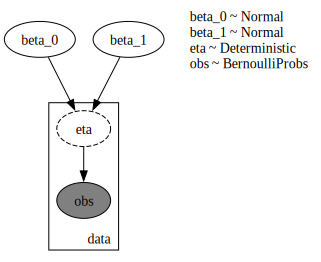

In [26]:
numpyro.render_model(glm, render_distributions=True, render_params=True, model_args=(
    jnp.asarray(df['target_present'].values).astype(int),
    jnp.asarray(df['response_yes'].values).astype(int)
))

## Extended GLM

The following model extends the simple GLM by adding dependencies of **beta_0** (criterion) and **beta_1** (d') on the parameters of each trial.

The relationship is modelled by a simple linear equation.

In [33]:
def extended_glm(
    target_present : jnp.ndarray, 
    distance_setting : jnp.ndarray,
    number_of_objects : jnp.ndarray,
    response_yes : Optional[jnp.ndarray] = None
) -> None:
    """
    Fits an equal variance gaussian SDT model based on a probit GLM to the data.
    The model is extended with model parameters: distance_setting and number_of_objects.
    For discussion, see DeCarlo (1998).

    Parameters:
        target_present : jnp.ndarray
            For each trial, whether the trial contained a target.
            Each value can be 0 or 1.
        distance_setting : jnp.ndarray
            For each trial, the distance setting that the trial was parametrized with.
            The distance setting has to be remapped to numerical values:
                {high : 1, mid : 2, low : 3}
        number_of_objects : jnp.ndarray
            For each trial, the number of objects that were on display.
            The number of objects has to be remapped to numerical values:
                {2 : 1, 3 : 2, 4 : 3, 8 : 4, 16 : 5}
        response_yes : jnp.ndarray
            For each trial, whether the participant responded yes on the yes-no task.
            Each value can be 0 or 1.
    
    Returns:
        None
    """
    # global parameters
    mu_d = mu_n = mu_i = 0
    sigma_d = sigma_n = sigma_i = 5

    n_distance_setting  = jnp.unique(distance_setting,  size=3).size
    n_number_of_objects = jnp.unique(number_of_objects, size=5).size

    # distance setting coefficients and intercepts for beta_0 and beta_1
    with numpyro.plate('distance_setting', n_distance_setting):
        # coefficients
        d_0 = numpyro.sample('d_0', dist.Normal(mu_d, sigma_d))
        d_1 = numpyro.sample('d_1', dist.Normal(mu_d, sigma_d))

        # intercepts
        id_0 = numpyro.sample('id_0', dist.Normal(mu_i, sigma_i))
        id_1 = numpyro.sample('id_1', dist.Normal(mu_i, sigma_i))

    # number of objects coefficients and intercepts for beta_0 and beta_1
    with numpyro.plate('number_of_objects', n_number_of_objects):
        # coefficients
        n_0 = numpyro.sample('n_0', dist.Normal(mu_n, sigma_n))
        n_1 = numpyro.sample('n_1', dist.Normal(mu_n, sigma_n))

        # intercepts
        in_0 = numpyro.sample('in_0', dist.Normal(mu_i, sigma_i))
        in_1 = numpyro.sample('in_1', dist.Normal(mu_i, sigma_i))

    # intercept aka criterion
    beta_0 = numpyro.deterministic('beta_0', value=id_0[distance_setting] + d_0[distance_setting] * distance_setting + in_0[number_of_objects] + n_0[number_of_objects] * number_of_objects)

    # slope aka d'
    beta_1 = numpyro.deterministic('beta_1', value=id_1[distance_setting] + d_1[distance_setting] * distance_setting + in_1[number_of_objects] + n_1[number_of_objects] * number_of_objects)
    
    with numpyro.plate(name='data', size=target_present.size):
        # linear predictor
        eta = numpyro.deterministic(name='eta', value=beta_0 + beta_1 * target_present)

        # probit link
        p = dist.Normal().cdf(eta)
        
        numpyro.sample('obs', dist.Bernoulli(probs=p), obs=response_yes)

In [34]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(extended_glm)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(
    rng_key_,
    target_present=jnp.asarray(df['target_present'].values).astype(int),
    distance_setting=jnp.asarray(df['distance_setting_code'].values).astype(int),
    number_of_objects=jnp.asarray(df['number_of_objects_code'].values).astype(int),
    response_yes=jnp.asarray(df['response_yes'].values).astype(int)
)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [32:54<00:00,  1.52it/s, 1023 steps of size 3.92e-05. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    d_0[0]     -0.21      0.00     -0.21     -0.21     -0.21      3.37      1.85
    d_0[1]      0.71      0.00      0.71      0.71      0.71     11.92      1.06
    d_0[2]     -0.31      0.00     -0.31     -0.32     -0.30      2.71      2.19
    d_1[0]      1.87      0.00      1.87      1.87      1.88      3.14      2.02
    d_1[1]      2.15      0.00      2.15      2.15      2.15      5.69      1.25
    d_1[2]      0.48      0.02      0.47      0.44      0.51      2.61      2.43
   id_0[0]     -1.47      0.00     -1.47     -1.47     -1.47     10.24      1.18
   id_0[1]     -0.13      0.00     -0.13     -0.13     -0.13      2.75      2.20
   id_0[2]      1.44      0.00      1.44      1.43      1.44      3.02      1.75
   id_1[0]      0.55      0.00      0.55      0.55      0.56      2.55      2.66
   id_1[1]      0.65      0.00      0.65      0.65      0.65      3.20      1.90
   id_1[2]      0.99      0

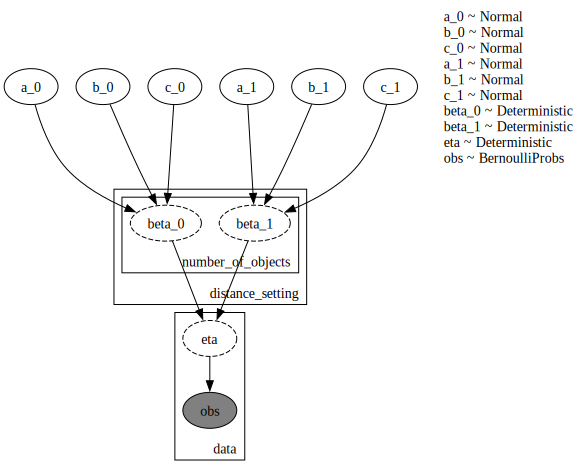

In [ ]:
numpyro.render_model(extended_glm, render_distributions=True, render_params=True, model_args=(
    jnp.asarray(df['target_present'].values).astype(int),
    jnp.asarray(df['distance_setting'].map({'high' : 1, 'mid' : 2, 'low' : 3}).values),
    jnp.asarray(df['number_of_objects'].map({2 : 1, 3 : 2, 4 : 3, 8 : 4, 16 : 5}).values),
    jnp.asarray(df['response_yes'].values).astype(int)
))